Note: For easy navigation, please use the Table of contents
## **Section 0: Name**
Pamela Sin Hui

## **Section 1: Project Title**
Tweet Sentiment Extraction - Extract support phrases for sentiment labels


## **Section 2: Goals, Dataset, Tasks**
**1. Goals**
The objective is to construct a model that can do the same - look at the labeled sentiment for a given tweet and figure out what word or phrase best supports it.

What words in tweets support a positive, negative, or neutral sentiment? 

"My ridiculous dog is amazing." [sentiment: positive] --> "amazing"

https://www.kaggle.com/c/tweet-sentiment-extraction/overview/description

https://www.kaggle.com/gskdhiman/bert-baseline-starter-kernel-ner-approach

**2. Dataset**

*   **train.csv** - 4 Columns (textID, text, selected_text, sentiment)
*   **test.csv** - 3 Columns (textID, text, sentiment)
*   **sample_submission.csv** 

**3. Tasks**

*   Data exploration
*   Create train and validation datasets from train.csv
*   Create model to predict sentiment from text (BERT + pytorch) - See Sentiment_Analysis_BERT.ipynb
*   Create model to predict selected text from text and sentiment (BERT + keras)
*   Check model performance and metrics
*   Ideas for improvement

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import the necessary libraries

In [ ]:
!pip install transformers
import os
import gc
import numpy as np 
import pandas as pd
import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import BertTokenizer,BertConfig,TFBertModel
from tqdm import tqdm
tqdm.pandas()

     |████████████████████████████████| 1.3MB 8.8MB/s 
     |████████████████████████████████| 1.1MB 50.8MB/s 
     |████████████████████████████████| 2.9MB 51.7MB/s 
     |████████████████████████████████| 890kB 47.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=8dd6c82bf5b242e5765d5c5bb19f6da7464b331a469d4eb5d148c5ffa1eed688
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
DATA_PATH = '/content/drive/My Drive/tweet_sentiment_extraction/'
train_df = pd.read_csv(DATA_PATH+'train.csv')
test_df = pd.read_csv(DATA_PATH+'test.csv')

In [ ]:
class config:
    MAX_LEN = 128
    TRAIN_BATCH_SIZE = 32
    VALID_BATCH_SIZE = 32
    TEST_BATCH_SIZE = 32
    EPOCHS = 5

    BERT_PATH = '/content/drive/My Drive/tweet_sentiment_extraction/bert/'
    TOKENIZER = tokenizers.BertWordPieceTokenizer(f"{BERT_PATH}/bert-base-uncased-vocab.txt", lowercase=True)
    SAVEMODEL_PATH_NEGATIVE = '/content/drive/My Drive/tweet_sentiment_extraction/bert/negative.h5'
    SAVEMODEL_PATH_NEUTRAL = '/content/drive/My Drive/tweet_sentiment_extraction/bert/neutral.h5'
    SAVEMODEL_PATH_POSITIVE = '/content/drive/My Drive/tweet_sentiment_extraction/bert/positive.h5'
    THRESHOLD = 0.4

## **Section 3: Data Engineering**
*   Data exploration

In [ ]:
print(train_df.shape)
train_df.head(3)

(27481, 4)


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative


In [ ]:
print(test_df.shape)
test_df.head(3)

(3534, 3)


,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative


In [ ]:
#cmaps['Perceptually Uniform Sequential'] = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
#cmaps['Sequential'] = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu','GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
temp = train_df.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='plasma')

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


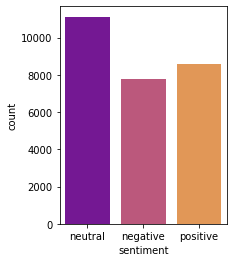

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(3,4))
sns.countplot(x='sentiment',data=train_df, palette = 'plasma')

In [ ]:
temp = test_df.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='plasma')

,sentiment,text
1,neutral,1430
2,positive,1103
0,negative,1001


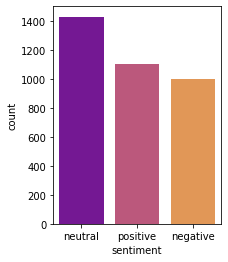

In [ ]:
plt.figure(figsize=(3,4))
sns.countplot(x='sentiment',data=test_df, palette = 'plasma')

In [ ]:
def jaccard(str1, str2): 
  a = set(str1.lower().split()) 
  b = set(str2.lower().split())
  c = a.intersection(b)
  return float(len(c)) / (len(a) + len(b) - len(c))

In [ ]:
train_df_eda = train_df.copy()
train_df_eda['jaccard'] = train_df_eda.progress_apply(lambda row: jaccard(
                                                                    str(row['text']), 
                                                                    str(row['selected_text'])),
                                                                    axis=1)
train_df_eda['text_num_words'] = train_df_eda['text'].apply(lambda x:len(str(x).split()))
train_df_eda['selected_text_num_words'] = train_df_eda['selected_text'].apply(lambda x:len(str(x).split()))
train_df_eda['difference_num_words'] = train_df_eda['text_num_words'] - train_df_eda['selected_text_num_words']
train_df_eda.head(3)

100%|██████████| 27481/27481 [00:00<00:00, 41589.14it/s]


,textID,text,selected_text,sentiment,jaccard,text_num_words,selected_text_num_words,difference_num_words
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000,7,7,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000,10,2,8
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,5,2,3


{'while', 'yours', 'but', 'me', 'until', 'whom', "you've", "there's", 'cannot', 'against', 'can', 'or', "hasn't", 'before', "wouldn't", "we'll", 'if', 'than', 'the', "where's", 'to', "aren't", 'other', "hadn't", 'nor', 'ought', 'who', "let's", 'once', 'theirs', "we've", "he'd", 'be', 'itself', 'her', 'however', "you'd", 'few', 'own', "we'd", 'as', 'only', "wasn't", "isn't", 'in', 'shall', "don't", 'any', "you'll", 'how', 'also', 'no', 'i', 'could', "didn't", 'there', 'over', 'here', 'when', 'this', 'where', 'doing', 'otherwise', 'a', "we're", 'our', 'again', 'he', 'has', 'so', 'through', 'his', 'have', "how's", 'further', 'been', 'like', "mustn't", 'k', "that's", 'himself', 'down', 'more', 'both', 'an', "haven't", 'ours', "they'll", 'we', 'by', 'that', "they've", 'yourself', "shouldn't", 'into', 'my', 'do', 'had', 'get', 'www', 'their', 'yourselves', "here's", "i've", 'else', 'ever', 'it', 'you', "when's", 'and', 'on', "they'd", 'are', 'about', 'herself', "she's", "couldn't", "weren't"

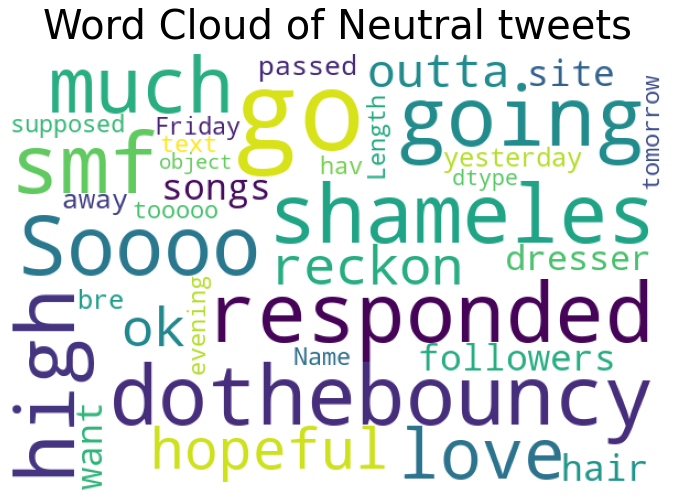

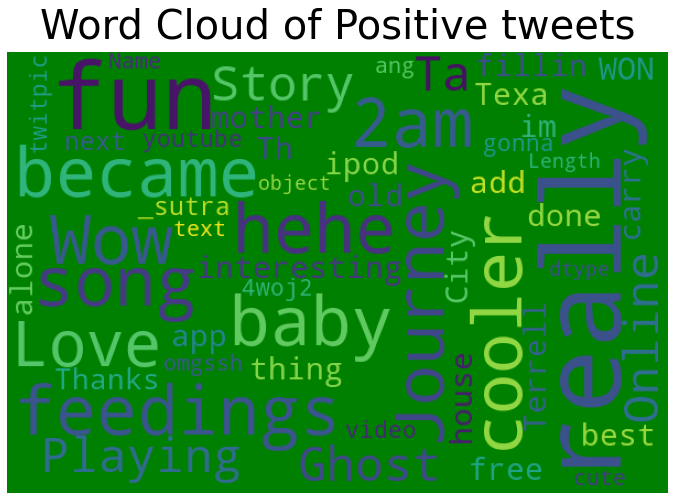

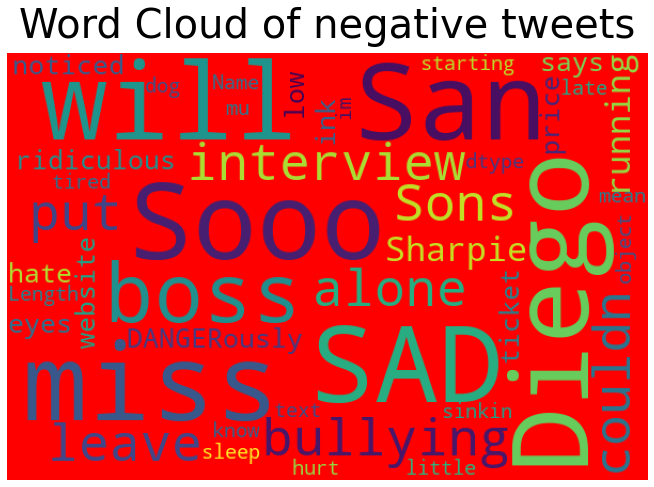

In [ ]:
from wordcloud import WordCloud, STOPWORDS
print(STOPWORDS)

def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(10,7), color = 'white',
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(background_color=color,
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    #random_state = 42,
                    width=600, 
                    height=400,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)

    plt.imshow(wordcloud);
    plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(train_df.loc[train_df['sentiment'] == 'neutral', 'text'].append(test_df.loc[test_df['sentiment'] == 'neutral', 'text']), title="Word Cloud of Neutral tweets",color = 'white')
plot_wordcloud(train_df.loc[train_df['sentiment'] == 'positive', 'text'].append(test_df.loc[test_df['sentiment'] == 'positive', 'text']), title="Word Cloud of Positive tweets",color = 'green')
plot_wordcloud(train_df.loc[train_df['sentiment'] == 'negative', 'text'].append(test_df.loc[test_df['sentiment'] == 'negative', 'text']), title="Word Cloud of negative tweets",color = 'red')

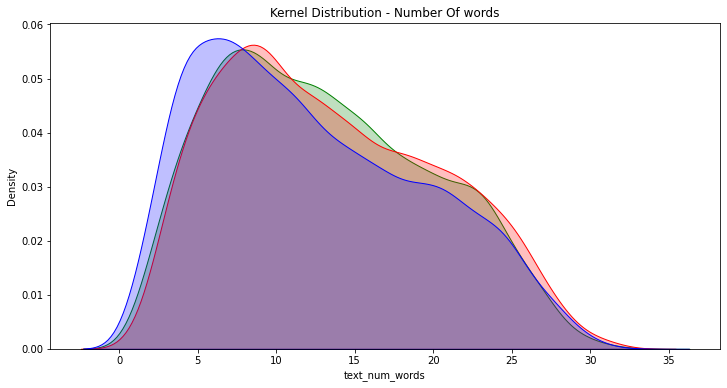

In [ ]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train_df_eda.loc[train_df_eda['sentiment'] == 'positive','text_num_words'], shade=True, color="g").set_title('Kernel Distribution - Number Of words')
p1=sns.kdeplot(train_df_eda.loc[train_df_eda['sentiment'] == 'negative','text_num_words'], shade=True, color="r")
p1=sns.kdeplot(train_df_eda.loc[train_df_eda['sentiment'] == 'neutral','text_num_words'], shade=True, color="b")

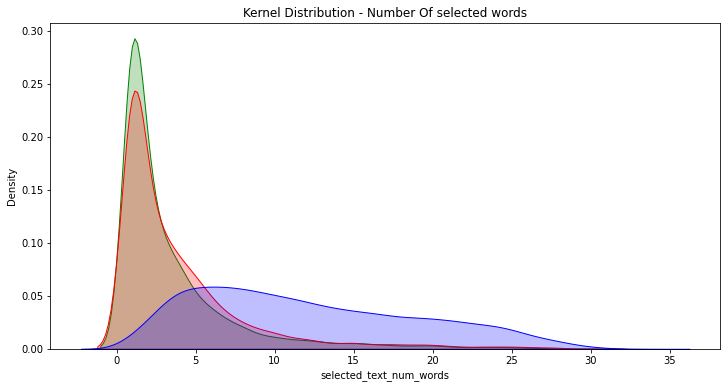

In [ ]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train_df_eda.loc[train_df_eda['sentiment'] == 'positive','selected_text_num_words'], shade=True, color="g").set_title('Kernel Distribution - Number Of selected words')
p1=sns.kdeplot(train_df_eda.loc[train_df_eda['sentiment'] == 'negative','selected_text_num_words'], shade=True, color="r")
p1=sns.kdeplot(train_df_eda.loc[train_df_eda['sentiment'] == 'neutral','selected_text_num_words'], shade=True, color="b")

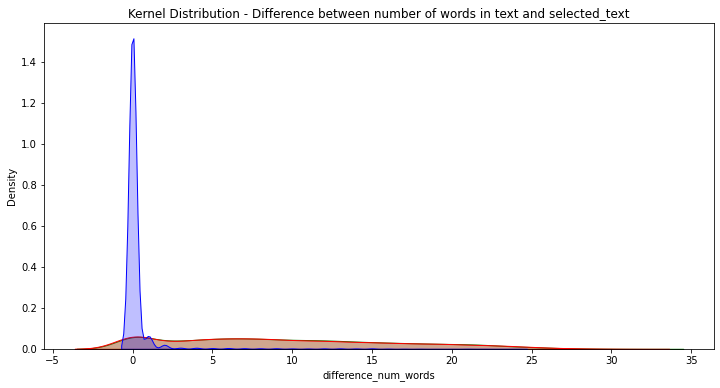

In [ ]:
plt.figure(figsize=(12,6))
p1=sns.kdeplot(train_df_eda.loc[train_df_eda['sentiment'] == 'positive','difference_num_words'], shade=True, color="g").set_title('Kernel Distribution - Difference between number of words in text and selected_text')
p1=sns.kdeplot(train_df_eda.loc[train_df_eda['sentiment'] == 'negative','difference_num_words'], shade=True, color="r")
p1=sns.kdeplot(train_df_eda.loc[train_df_eda['sentiment'] == 'neutral','difference_num_words'], shade=True, color="b")

# Create Targets

## **Section 4: Feature Engineering**
*   Using BERT for meaning

In [ ]:
#What does tokenizers.BertWordPieceTokenizer do?
tweet_encoded = config.TOKENIZER.encode('Trying out this cool tokenizer')
print('tokens:             ', tweet_encoded.tokens)
print('ids:                ' ,tweet_encoded.ids)
print('type_ids:           ' ,tweet_encoded.type_ids)
print('offsets:            ', tweet_encoded.offsets)
print('attention_mask:     ' , tweet_encoded.attention_mask)
print('special_tokens_mask:', tweet_encoded.special_tokens_mask)
print('overflowing:        ', tweet_encoded.overflowing)

tokens:              ['[CLS]', 'trying', 'out', 'this', 'cool', 'token', '##izer', '[SEP]']
ids:                 [101, 2667, 2041, 2023, 4658, 19204, 17629, 102]
type_ids:            [0, 0, 0, 0, 0, 0, 0, 0]
offsets:             [(0, 0), (0, 6), (7, 10), (11, 15), (16, 20), (21, 26), (26, 30), (0, 0)]
attention_mask:      [1, 1, 1, 1, 1, 1, 1, 1]
special_tokens_mask: [1, 0, 0, 0, 0, 0, 0, 1]
overflowing:         []


In [ ]:
def process_data(tweet, selected_text, tokenizer):
    len_st = len(selected_text)
    idx0 = None
    idx1 = None

    #Because of the break, it only finds the first match
    for ind in (i for i, e in enumerate(tweet) if e == selected_text[0]):
        if tweet[ind: ind+len_st] == selected_text:
            idx0 = ind
            idx1 = ind + len_st
            break

    char_targets = [0] * len(tweet)
    if idx0 != None and idx1 != None:
        for ct in range(idx0, idx1):
            char_targets[ct] = 1
            
    tok_tweet = tokenizer.encode(tweet)
    input_ids_orig = tok_tweet.ids
    tweet_offsets = tok_tweet.offsets

    target_idx = []
    for j, (offset1, offset2) in enumerate(tweet_offsets):
        if sum(char_targets[offset1: offset2]) > 0:
            target_idx.append(j)
            
    targets = [0] * len(input_ids_orig)
    for idx in target_idx:
        targets[idx] = 1
    return targets

In [ ]:
#split into three seperate dataframes, shuffle, further split into train and validation sets
`

train_df_negative = train_df.copy()
train_df_negative = train_df_negative.loc[train_df_negative['sentiment'] == 'negative', :].sample(frac=1)
train_df_negative, val_df_negative = train_test_split(train_df_negative, test_size = 0.2)
print('Negative sentiment: Train size =', train_df_negative.shape[0], ', Val size =', val_df_negative.shape[0])

train_df_neutral = train_df.copy()
train_df_neutral = train_df_neutral.loc[train_df_neutral['sentiment'] == 'neutral', :].sample(frac=1)
train_df_neutral, val_df_neutral = train_test_split(train_df_neutral, test_size = 0.2)
print('Neutral sentiment: Train size =', train_df_neutral.shape[0], ', Val size =', val_df_neutral.shape[0])

train_df_positive = train_df.copy()
train_df_positive = train_df_positive.loc[train_df_positive['sentiment'] == 'positive', :].sample(frac=1)
train_df_positive, val_df_positive = train_test_split(train_df_positive, test_size = 0.2)
print('Positive sentiment: Train size =', train_df_positive.shape[0], ', Val size =', val_df_positive.shape[0])

#get targets column
list_of_df = [train_df_negative, val_df_negative, train_df_neutral, val_df_neutral, train_df_positive, val_df_positive]
for df in list_of_df:
  df['targets'] = df.progress_apply(lambda row: process_data(str(row['text']), str(row['selected_text']), config.TOKENIZER), axis=1)
  df['targets'] = df['targets'].apply(lambda x :x + [0] * (config.MAX_LEN-len(x)))

train_df_negative.head(3)

 16%|█▌        | 967/6224 [00:00<00:00, 9660.75it/s]

Negative sentiment: Train size = 6224 , Val size = 1557
Neutral sentiment: Train size = 8894 , Val size = 2224
Positive sentiment: Train size = 6865 , Val size = 1717


100%|██████████| 1717/1717 [00:00<00:00, 9019.01it/s]


,textID,text,selected_text,sentiment,targets
3486,7527ed21ee,I`m so unhappy being here. I hate it. It`s aff...,I`m so unhappy being here. I hate it.,negative,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ..."
4358,d10467dde7,"yes! fb, ah i miss you",miss,negative,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
26077,f532604ee6,doesn`t want to go to work....,doesn`t want to go to work..,negative,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ..."


Convert into Bert Format

In [ ]:
def _convert_to_transformer_inputs(text, tokenizer, max_sequence_length):
    inputs = tokenizer.encode(text)
    input_ids =  inputs.ids
    input_masks = inputs.attention_mask
    input_segments = inputs.type_ids
    padding_length = max_sequence_length - len(input_ids)
    padding_id = 0
    input_ids = input_ids + ([padding_id] * padding_length)
    input_masks = input_masks + ([0] * padding_length)
    input_segments = input_segments + ([0] * padding_length)
    return [input_ids, input_masks, input_segments]

def compute_input_arrays(df, tokenizer, max_sequence_length):
    input_ids, input_masks, input_segments = [], [], []
    for _, instance in tqdm(df.iterrows()):
        ids, masks, segments= _convert_to_transformer_inputs(str(instance.text),tokenizer, max_sequence_length)
        input_ids.append(ids)
        input_masks.append(masks)
        input_segments.append(segments)
        
    return [np.asarray(input_ids, dtype=np.int32), 
            np.asarray(input_masks, dtype=np.int32), 
            np.asarray(input_segments, dtype=np.int32)]

def compute_output_arrays(df, columns):
    return np.asarray(df[columns].values.tolist())

In [ ]:
#Testing out our defined function
max_sequence_length = 25
input_ids, input_masks, input_segments = _convert_to_transformer_inputs('Trying out this cool tokenizer', config.TOKENIZER, max_sequence_length)
print('input_ids     : ', input_ids)
print('input_masks   : ', input_masks)
print('input_segments: ', input_segments)

input_ids     :  [101, 2651, 2003, 5875, 1012, 2190, 2154, 2412, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
input_masks   :  [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
input_segments:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
inputs_train_negative = compute_input_arrays(train_df_negative, config.TOKENIZER, config.MAX_LEN)
outputs_train_negative = compute_output_arrays(train_df_negative,'targets')
inputs_val_negative = compute_input_arrays(val_df_negative, config.TOKENIZER, config.MAX_LEN)
outputs_val_negative = compute_output_arrays(val_df_negative,'targets')

inputs_train_neutral = compute_input_arrays(train_df_neutral, config.TOKENIZER, config.MAX_LEN)
outputs_train_neutral = compute_output_arrays(train_df_neutral,'targets')
inputs_val_neutral = compute_input_arrays(val_df_neutral, config.TOKENIZER, config.MAX_LEN)
outputs_val_neutral = compute_output_arrays(val_df_neutral,'targets')

inputs_train_positive = compute_input_arrays(train_df_positive, config.TOKENIZER, config.MAX_LEN)
outputs_train_positive = compute_output_arrays(train_df_positive,'targets')
inputs_val_positive = compute_input_arrays(val_df_positive, config.TOKENIZER, config.MAX_LEN)
outputs_val_positive = compute_output_arrays(val_df_positive,'targets')

6224it [00:01, 4715.30it/s]
1557it [00:00, 4885.34it/s]
8894it [00:01, 5049.66it/s]
2224it [00:00, 5105.60it/s]
6865it [00:01, 4983.65it/s]
1717it [00:00, 5065.93it/s]


## **Section 5: Model Engineering**

In [ ]:
def create_model():
    ids = tf.keras.layers.Input((config.MAX_LEN,), dtype=tf.int32)
    mask = tf.keras.layers.Input((config.MAX_LEN,), dtype=tf.int32)
    attn = tf.keras.layers.Input((config.MAX_LEN,), dtype=tf.int32)
    bert_conf = BertConfig() 
    #bert_conf.output_hidden_states = True
    bert_model = TFBertModel.from_pretrained(config.BERT_PATH +'/bert-base-uncased-tf_model.h5', config=bert_conf)
    
    output_bert = bert_model(ids, attention_mask=mask, token_type_ids=attn)
    
    x = tf.keras.layers.Dropout(0.1)(output_bert[0]) 
    x = tf.keras.layers.Conv1D(1,1)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Activation('sigmoid')(x)
    model = tf.keras.models.Model(inputs=[ids, mask, attn], outputs=x)
    return model

Training

In [ ]:
K.clear_session()
model_negative = create_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
model_negative.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

if not os.path.exists(config.SAVEMODEL_PATH_NEGATIVE):
    #model.fit(inputs,outputs, epochs=config.EPOCHS, batch_size=config.TRAIN_BATCH_SIZE)
    model_negative.fit(inputs_train_negative, outputs_train_negative, epochs=config.EPOCHS, batch_size=config.TRAIN_BATCH_SIZE, validation_data=(inputs_val_negative, outputs_val_negative))
    model_negative.save_weights(f'/content/drive/My Drive/tweet_sentiment_extraction/bert/negative.h5')
else:
    model_negative.load_weights(config.SAVEMODEL_PATH_NEGATIVE)

Some layers from the model checkpoint at /content/drive/My Drive/tweet_sentiment_extraction/bert//bert-base-uncased-tf_model.h5 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at /content/drive/My Drive/tweet_sentiment_extraction/bert//bert-base-uncased-tf_model.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
98/98 [==============================] - 95s 971ms/step - loss: 0.1015 - accuracy: 0.2272 - val_loss: 0.0817 - val_accuracy: 0.3192
Epoch 2/5
98/98 [==============================] - 92s 938ms/step - loss: 0.0767 - accuracy: 0.3326 - val_loss: 0.0773 - val_accuracy: 0.3378
Epoch 3/5
98/98 [==============================] - 92s 938ms/step - loss: 0.0668 - accuracy: 0.3507 - val_loss: 0.0767 - val_accuracy: 0.3365
Epoch 4/5
98/98 [==============================] - 92s 937ms/step - loss: 0.0537 - accuracy: 0.3671 - val_loss: 0.0893 - val_accuracy: 0.3378
Epoch 5/5
98/98 [==============================] - 92s 937ms/step - loss: 0.0381 - accuracy: 0.3663 - val_loss: 0.1031 - val_accuracy: 0.3372


In [ ]:
K.clear_session()
model_neutral = create_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
model_neutral.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

if not os.path.exists(config.SAVEMODEL_PATH_NEUTRAL):
    model_neutral.fit(inputs_train_neutral, outputs_train_neutral, epochs=config.EPOCHS, batch_size=config.TRAIN_BATCH_SIZE, validation_data=(inputs_val_neutral, outputs_val_neutral))
    model_neutral.save_weights(f'/content/drive/My Drive/tweet_sentiment_extraction/bert/neutral.h5')
else:
    model_neutral.load_weights(config.SAVEMODEL_PATH_NEUTRAL)

Some layers from the model checkpoint at /content/drive/My Drive/tweet_sentiment_extraction/bert//bert-base-uncased-tf_model.h5 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at /content/drive/My Drive/tweet_sentiment_extraction/bert//bert-base-uncased-tf_model.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
139/139 [==============================] - 134s 968ms/step - loss: 0.0347 - accuracy: 0.1277 - val_loss: 0.0174 - val_accuracy: 0.1682
Epoch 2/5
139/139 [==============================] - 132s 947ms/step - loss: 0.0190 - accuracy: 0.1179 - val_loss: 0.0173 - val_accuracy: 0.1641
Epoch 3/5
139/139 [==============================] - 131s 946ms/step - loss: 0.0166 - accuracy: 0.1161 - val_loss: 0.0174 - val_accuracy: 0.1389
Epoch 4/5
139/139 [==============================] - 132s 948ms/step - loss: 0.0120 - accuracy: 0.1111 - val_loss: 0.0192 - val_accuracy: 0.1012
Epoch 5/5
139/139 [==============================] - 131s 945ms/step - loss: 0.0084 - accuracy: 0.0779 - val_loss: 0.0206 - val_accuracy: 0.0692


In [ ]:
K.clear_session()
model_positive = create_model()
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
model_positive.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

if not os.path.exists(config.SAVEMODEL_PATH_POSITIVE):
    model_positive.fit(inputs_train_positive, outputs_train_positive, epochs=config.EPOCHS, batch_size=config.TRAIN_BATCH_SIZE, validation_data = (inputs_val_positive, outputs_val_positive))
    model_positive.save_weights(f'/content/drive/My Drive/tweet_sentiment_extraction/bert/positive.h5')
else:
    model_positive.load_weights(config.SAVEMODEL_PATH_POSITIVE)

Some layers from the model checkpoint at /content/drive/My Drive/tweet_sentiment_extraction/bert//bert-base-uncased-tf_model.h5 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at /content/drive/My Drive/tweet_sentiment_extraction/bert//bert-base-uncased-tf_model.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Epoch 1/5
215/215 [==============================] - 111s 518ms/step - loss: 0.0843 - accuracy: 0.3780 - val_loss: 0.0719 - val_accuracy: 0.4834
Epoch 2/5
215/215 [==============================] - 108s 504ms/step - loss: 0.0644 - accuracy: 0.4712 - val_loss: 0.0689 - val_accuracy: 0.4770
Epoch 3/5
215/215 [==============================] - 108s 504ms/step - loss: 0.0551 - accuracy: 0.4752 - val_loss: 0.0689 - val_accuracy: 0.4729
Epoch 4/5
215/215 [==============================] - 108s 504ms/step - loss: 0.0423 - accuracy: 0.4838 - val_loss: 0.0847 - val_accuracy: 0.4613
Epoch 5/5
215/215 [==============================] - 108s 504ms/step - loss: 0.0312 - accuracy: 0.4867 - val_loss: 0.0930 - val_accuracy: 0.4735


# Prediction

In [ ]:
!pip install -q -U watermark
!pip install -qq transformers
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

MAX_LEN = 160

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.1.3
torch 1.6.0+cu101
transformers 3.4.0


In [ ]:
from transformers import *
import torch.nn as nn
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
test_df.head(3)

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative


In [ ]:
from tensorflow.keras.models import load_model
import torch

class_names = ['negative', 'neutral', 'positive']
model = SentimentClassifier(len(class_names))
base_model = torch.load('/content/drive/My Drive/tweet_sentiment_extraction/best_model_state.bin')
model.load_state_dict(base_model)

def predictor (review_text):
  encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',)

  input_ids = encoded_review['input_ids']
  attention_mask = encoded_review['attention_mask']

  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)
  return class_names[prediction]

test_df['sentiment_predict'] = test_df['text'].apply(lambda x:predictor(x))
test_df.sample(20)

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


,textID,text,sentiment,sentiment_predict
697,0c79867978,My net died so yeah.... I`m sad now,negative,negative
376,80ea9ba96f,had a lovely breakfast with mum...yummy pancakes,positive,positive
2791,5773cb0640,how poetic.. great going.. keep them coming,positive,positive
1889,9114d80bac,Laundry time and LOTS of it!,neutral,positive
999,80aff8d880,bout 2 have 1 more drink then imma head in da ...,neutral,neutral
711,5bbef6942a,Well tell me what fashion tips you need and I...,positive,neutral
812,47b4e91e39,rmbr the time when we torned for the night in ...,neutral,neutral
3091,2e982cc27d,She`s the ruddy manageress - 2nd bad job from...,negative,negative
1748,edd38781e4,Its seriously quiet and lonely here without Bunny,negative,negative
3059,37daa255ea,haha i just realised it sounded a lot like st...,positive,positive


In [ ]:
#split test set into 3 dataframes based on sentiment - change to test_df['sentiment_predict' to use the predicted sentiment]
test_negative = test_df.loc[test_df['sentiment'] == 'negative', :]
test_neutral = test_df.loc[test_df['sentiment'] == 'neutral', :]
test_positive = test_df.loc[test_df['sentiment'] == 'positive', :]

#prepare model inputs for each sentiment
test_negative_inputs = compute_input_arrays(test_negative, config.TOKENIZER, config.MAX_LEN)
test_neutral_inputs = compute_input_arrays(test_neutral, config.TOKENIZER, config.MAX_LEN)
test_positive_inputs = compute_input_arrays(test_positive, config.TOKENIZER, config.MAX_LEN)

#create_model
model_negative = create_model()
model_neutral = create_model()
model_positive = create_model()

#load_weights
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5)
model_negative.load_weights(config.SAVEMODEL_PATH_NEGATIVE)
model_neutral.load_weights(config.SAVEMODEL_PATH_NEUTRAL)
model_positive.load_weights(config.SAVEMODEL_PATH_POSITIVE)

#predictions
predictions_negative = model_negative.predict(test_negative_inputs, batch_size=32, verbose=1)
predictions_neutral = model_neutral.predict(test_neutral_inputs, batch_size=32, verbose=1)
predictions_positive = model_positive.predict(test_positive_inputs, batch_size=32, verbose=1)

#re-setting index of dataframes
test_negative.reset_index(inplace=True, drop=True)
test_neutral.reset_index(inplace=True, drop=True)
test_positive.reset_index(inplace=True, drop=True)

1001it [00:00, 5204.11it/s]
1430it [00:00, 5227.71it/s]
1103it [00:00, 5194.25it/s]
Some layers from the model checkpoint at /content/drive/My Drive/tweet_sentiment_extraction/bert//bert-base-uncased-tf_model.h5 were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at /content/drive/My Drive/tweet_sentiment_extraction/bert//bert-base-uncased-tf_model.h5.
If your task is similar to the task the model of the checkpoint was trained on, you can already

35/35 [==============================] - 9s 256ms/step


In [ ]:
predictions_positive

array([[3.6181750e-06, 2.7194086e-01, 3.3064699e-01, ..., 7.2479742e-07,
        6.8119527e-07, 7.3334388e-07],
       [3.2262988e-06, 9.9743819e-01, 5.8970493e-01, ..., 1.3523372e-06,
        1.1531019e-06, 1.3465230e-06],
       [6.8445715e-06, 1.4558884e-04, 1.2357025e-04, ..., 1.7462860e-06,
        1.6786697e-06, 1.6355774e-06],
       ...,
       [4.8224265e-06, 1.1157299e-03, 7.3050649e-04, ..., 1.4976389e-06,
        1.5119899e-06, 1.7001411e-06],
       [4.7369163e-06, 8.3207188e-04, 3.3470895e-03, ..., 1.3329580e-06,
        1.3530649e-06, 1.4417799e-06],
       [6.7679662e-06, 2.0214255e-04, 2.2165845e-04, ..., 1.9644262e-06,
        1.8976879e-06, 2.0527254e-06]], dtype=float32)

In [ ]:
def decode_tweet(original_tweet,idx_start,idx_end,offsets):
    filtered_output  = ""
    for ix in range(idx_start, idx_end + 1):
        filtered_output += original_tweet[offsets[ix][0]: offsets[ix][1]]
        if (ix+1) < len(offsets) and offsets[ix][1] < offsets[ix+1][0]:
            filtered_output += " "
    return filtered_output

In [ ]:
threshold = config.THRESHOLD
outputs_negative = []
outputs_neutral = []  
outputs_positive= []

def generate_outputs(df, sentiment):
  if sentiment == 'negative':
    pred = np.where(predictions_negative>threshold,1,0)
  elif sentiment == 'neutral':
    pred = np.where(predictions_neutral>threshold,1,0)
  elif sentiment == 'positive':
    pred = np.where(predictions_positive>threshold,1,0)

  for test_idx in range(df.shape[0]):
    indexes = list(np.where(pred[test_idx]==1)[0])
    text = str(df.loc[test_idx,'text'])
    encoded_text = config.TOKENIZER.encode(text)
    if len(indexes)>0:
        start = indexes[0]
        end =  indexes[-1]
    else:  ### if we found nothing above threshold
        start = 0
        end = len(encoded_text.ids) - 1
    if end >= len(encoded_text.ids): ## -1 for SEP token at last
        end = len(encoded_text.ids) - 1
    if start>end: 
        selected_text = df.loc[test_idx,'text']
    else:
        selected_text = decode_tweet(text,start,end,encoded_text.offsets)
    if sentiment == 'negative':
      outputs_negative.append(selected_text)
    elif sentiment == 'neutral':
      outputs_neutral.append(selected_text)
    elif sentiment == 'positive':
      outputs_positive.append(selected_text)

generate_outputs(test_negative, 'negative')
generate_outputs(test_neutral, 'neutral')
generate_outputs(test_positive, 'positive')

test_negative['selected_text'] = outputs_negative
test_neutral['selected_text'] = outputs_neutral
test_positive['selected_text'] = outputs_positive

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [ ]:
test_negative.sample(10)

,textID,text,sentiment,sentiment_predict,selected_text
210,5496094dac,Feeling bad for profile pic,negative,negative,Feeling bad
996,975554343f,I just noticed that They are so ridiculous,negative,negative,are so ridiculous
256,bcc50747b1,_x How did your Geo ISU go? I swear I just had...,negative,negative,I swear I just had the worse day ever..
80,61e8b484df,Straighening my hair and its not going as stra...,negative,negative,bummerrr
133,89d9167173,So many farewell parties! sad to see people le...,negative,negative,sad
251,fb030409ab,30 year old Barbie dolls still can rock it...t...,negative,positive,30 year old Barbie dolls still can rock it...t...
818,d46052706c,I can`t find hope he didn`t get eaten by any...,negative,neutral,I can`t find hope he didn`t get eaten by anyth...
674,e7a714bd8a,my gawwddd ! 6 headshotss inna row? im on fyaa...,negative,neutral,my gawwddd !
358,b8293bb838,"Is on her way to nottingham! ICOF tonight, the...",negative,negative,Fail
749,81ef3d303f,Bummer. I hope it doesn`t continue too long.,negative,neutral,Bummer.


In [ ]:
#Neutral model appears to be taking the entire text as selected_text
test_neutral.sample(10)

,textID,text,sentiment,sentiment_predict,selected_text
519,7880cbca66,"Darn, I thought you meant White Sox.",neutral,neutral,"Darn, I thought you meant White Sox."
1283,1f9663bb46,Guys will go see Constance \t logically,neutral,neutral,Guys will go see Constance logically
470,0996990dca,Cleaning out my room and found this... http://...,neutral,neutral,Cleaning out my room and found this... http://...
1340,6d68218d8b,tMeme> My besties. If only was there. on Twi...,neutral,neutral,My besties. If only was there. on Twitpic: htt...
1351,ab65e404fd,Last time we`ll get tacos like this.,neutral,neutral,Last time we`ll get tacos like this.
116,086671fad9,ok. lol. i miss you too. i hope your cramps g...,neutral,neutral,ok. lol. i miss you too. i hope your cramps ge...
48,c8307a482d,learning tat the scenic way din plan to go t...,neutral,neutral,learning tat the scenic way din plan to go tow...
1104,ac75f9e59f,eating lunch. then school,neutral,neutral,eating lunch. then school
356,03e41eeb4f,"thanks Alen, it seems that we can only submit...",neutral,positive,"thanks Alen, it seems that we can only submit ..."
6,f0ef04109b,about to go to sleep,neutral,neutral,about to go to sleep


In [ ]:
test_positive.sample(10)

,textID,text,sentiment,sentiment_predict,selected_text
141,09fea0f3a7,"So happy, my VStudio shortcuts are backkk",positive,positive,"happy,"
404,2524332d66,I`m concerned for that family,positive,negative,I`m concerned for that family
917,08ad89c6b0,Hi .. I have the net YAYY.. Im here for a shor...,positive,neutral,YAYY.
882,4454e4d53a,"I`m not sure... But, 4719 fans in just a week...",positive,positive,a wow to me!
648,dabac40552,SUPER EXCITED. JUST BOUGHT MY TIX TO SEE HEY ...,positive,neutral,SUPER EXCITED.
134,e892068fd3,"lol that just totally made me laugh, which ma...",positive,positive,"totally made me laugh,"
193,13c47e9bc8,got an awesome hair cut todayyyy it looks so ...,positive,positive,awesome
915,e6f7199479,Rofl u did? Hahaha! Lemme tell Salman Munir ...,positive,positive,Hahaha!
680,416726e6d2,~ I`m sure that would make Mr. Koons very happy,positive,positive,very happy
1093,4cb0ab19ed,"Good morning, to all the mommies happy mothers...",positive,positive,", to all the mommies happy"


In [ ]:
#extra - input any text, output sentiment prediction and selected_text that gives rise to the sentiment
text = 'Today I was moody at first, but it turned out to be an exciting day'
sentiment_prediction = predictor(text)
temp_dict = {'text': [text], 'sentiment_prediction': [sentiment_prediction]}
temp_df = pd.DataFrame(temp_dict)

test_input = compute_input_arrays(temp_df, config.TOKENIZER, config.MAX_LEN)

if sentiment_prediction == 'negative':
  prediction = model_negative.predict(test_input, batch_size=32, verbose=1)
elif sentiment_prediction == 'neutral':
  prediction = model_neutral.predict(test_input, batch_size=32, verbose=1)
elif sentiment_prediction == 'positive':
  prediction = model_positive.predict(test_input, batch_size=32, verbose=1)

output = []

def generate_output(df, sentiment):
  pred = np.where(prediction>threshold,1,0)

  for test_idx in range(df.shape[0]):
    indexes = list(np.where(pred[test_idx]==1)[0])
    text = str(df.loc[test_idx,'text'])
    encoded_text = config.TOKENIZER.encode(text)
    if len(indexes)>0:
        start = indexes[0]
        end =  indexes[-1]
    else:  ### if we found nothing above threshold
        start = 0
        end = len(encoded_text.ids) - 1
    if end >= len(encoded_text.ids): ## -1 for SEP token at last
        end = len(encoded_text.ids) - 1
    if start>end: 
        selected_text = df.loc[test_idx,'text']
    else:
        selected_text = decode_tweet(text,start,end,encoded_text.offsets)

    output.append(selected_text)

generate_output(temp_df, sentiment_prediction)
temp_df['selected_text'] = output

print('Text: ', text)
print('Sentiment prediction: ' + sentiment_prediction)
print('Section of text prediction: ', output[0])

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1944: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
1it [00:00, 561.26it/s]

1/1 [==============================] - 0s 1ms/step
Text:  Today I was moody at first, but it turned out to be an exciting day
Sentiment prediction: positive
Section of text prediction:  it turned out to be an exciting day


## **Section 6 and 7: Evaluate Metrics, Observations and Analysis**
The model that predict sentiment had an accuracy of 0.77599 on the 'test' dataset (that was carved out from the train dataset). 

From the confusion matrix:
- The model has more difficulty predicting neutral sentiments, perhaps due to lack of defining words that leads one to think a tweet is neutral.
- If a tweet is more polar (negative or positive true sentiment), any misclassification is more likely from the classificaion to neutral instead of the polar opposite. 

The model that predicts the section of the text that gives rise to the sentiment:
- Negative sentiment - val_accuracy 0.3378
- Neutral sentiment - val_accuracy 0.1682
- Positive sentiment - val_accuracy 0.4834

Again this model finds it harder to determine which section of text gives rise to neutral sentiment. 


**Proposed improvements**
- Experiment with more decoder models (add dense layers, hyperparameter search)

- Run on more epochs after above

- Improve on selection of text for netural tweets (NER using spacy as certain cateogry of word types (perhaps like descriptors) gives sentiment)

- Use 1 - Jaccard score as loss function to better train model or as an evaluation metric instead of all-or-none approach with sigmoid

